References:


*   https://www.kaggle.com/code/nawidsayed/lightgbm-and-cnn-3rd-place-solution/notebook
*   https://www.kaggle.com/code/mks2192/list-of-fake-samples-and-public-private-lb-split/notebook
*   https://github.com/tianqwang/Santander-Customer-Transaction-Prediction







## Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline
import lightgbm as lightgbmclassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from tqdm import tqdm_notebook as tqdm
import scipy.ndimage
import tensorflow as tf
from sklearn import linear_model
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation, Conv1D, BatchNormalization, AveragePooling1D, Reshape
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils


import warnings
warnings.filterwarnings('ignore')

In [ ]:
import sys
!{sys.executable} -m pip install scikit-optimize

     |████████████████████████████████| 100 kB 2.4 MB/s 


In [ ]:
from skopt import BayesSearchCV

In [ ]:
RAND_STATE = 47
np.random.seed(RAND_STATE)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## EDA & Data Munging

### Data Exploration

In [ ]:
folder ='/content/drive/Shareddrives/MSBA 6420 Predictive Project/'

In [ ]:
df = pd.read_csv(folder + 'data/train.csv')
test_df = pd.read_csv(folder + 'data/test.csv')

In [ ]:
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


### Basic Data Transformations and Aggregations

In [ ]:
# There are no missing data in train and test datasets.
# Let's check the numerical values in train and test dataset.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [ ]:
# imbalanced dataset
df['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

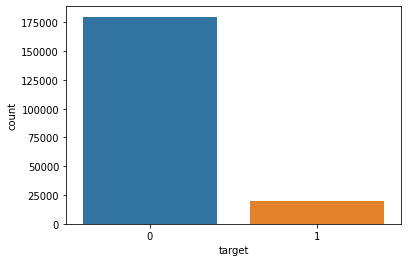

In [ ]:
#df['target'].astype(str).hist()
sns.countplot(df['target'])..set(title='Points by Team')


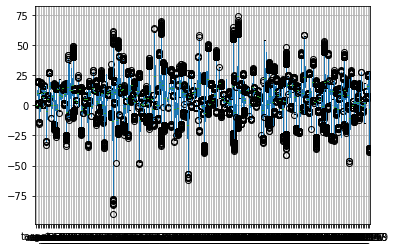

In [ ]:
# Normalization to be done after predictor and target variable
# have been declared and populated

df.boxplot()

#### Correlation Plots! 50 variables at a time!

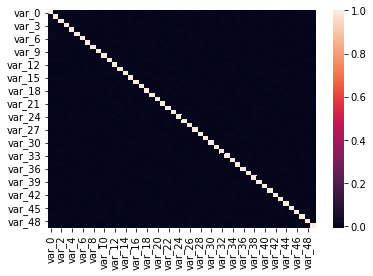

In [ ]:
sns.heatmap(df.iloc[:,2:52].corr())
plt.show()

In [ ]:
sns.heatmap(df.iloc[:,52:102].corr())

In [ ]:
sns.heatmap(df.iloc[:,102:152].corr())

In [ ]:
sns.heatmap(df.iloc[:,152:203].corr())

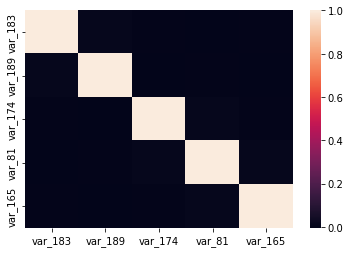

In [ ]:
sns.heatmap(df[['var_183', 'var_189', 'var_174', 'var_81', 'var_165']].corr())

#### Very low correlation among all the variables!

### Lets try to check the number of unique values in each column

In [ ]:
unique_val = df.iloc[:, 2:].nunique()
print('Top 5 columns having the most number of unique values!')
unique_val.sort_values(ascending=False).head().to_frame()

Top 5 columns having the most number of unique values!


,0
var_45,169968
var_117,164469
var_74,161058
var_61,159369
var_97,158739


In [ ]:
print('Top 5 columns having the least number of unique values!')
unique_val.sort_values(ascending=True).head().to_frame()

Top 5 columns having the least number of unique values!


,0
var_68,451
var_91,7962
var_108,8525
var_103,9376
var_12,9561


### Proof of Synthetic Data

In [ ]:
def plot_nunique(df_train, df_test):
    train_X = df_train[feature]
    test_X = df_test[feature]
    y = df_train['target']

    train_unique = train_X.nunique()
    test_unique = test_X.nunique()
    train_unique_0 = train_X[df_train['target']==0].nunique()
    train_unique_1 = train_X[df_train['target']==1].nunique()
    
    plt.figure(figsize=(20,8))
    plt.title("Unique Value Number for Each Group")
    plt.xlabel("Variables")
    plt.ylabel("Unique Value Counts")
    plt.plot(train_unique.values, label = 'train')
    plt.plot(train_unique_0.values, label = 'train_0')
    plt.plot(train_unique_1.values, label = 'train_1')
    plt.plot(test_unique.values[1:],label = 'test')
    plt.legend()

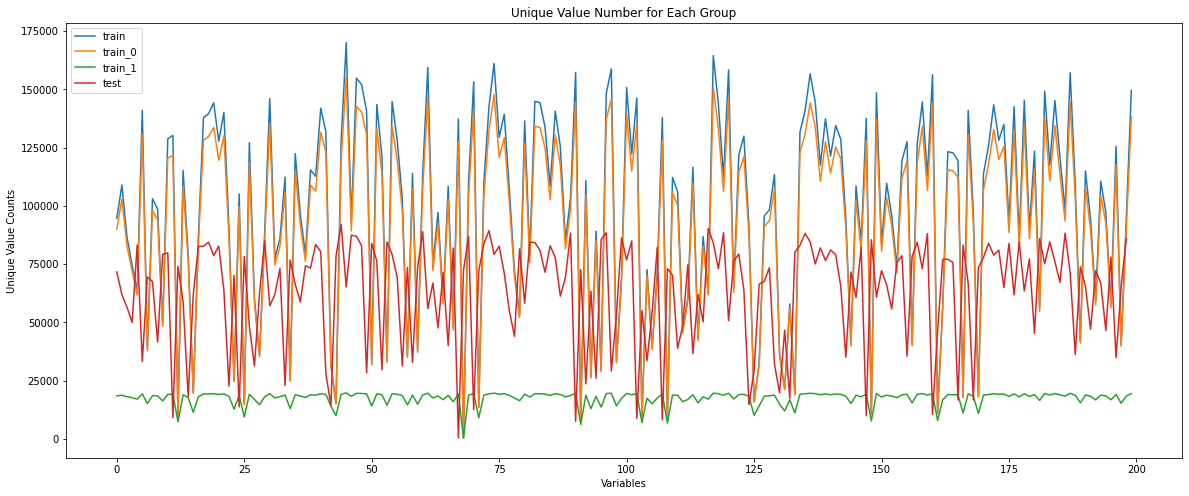

In [ ]:
plot_nunique(df, test_df)

### Splitting real and fake test data

If a row has at least one unique value in a feature, then it is real, otherwise it is synthetic. This technique is shared by YaG320 in this kernel List of Fake Samples and Public/Private LB split and it successfuly identifies synthetic samples in entire test set.
https://www.kaggle.com/code/yag320/list-of-fake-samples-and-public-private-lb-split/notebook

In [ ]:
test_df = test_set.copy()

In [ ]:
test_df.drop(['ID_code'], axis=1, inplace=True)
test_df = test_df.values

unique_samples = []
unique_count = np.zeros_like(test_df)
for feature in range(test_df.shape[1]):
    _, index_, count_ = np.unique(test_df[:, feature], return_counts=True, return_index=True)
    unique_count[index_[count_ == 1], feature] += 1

# Samples which have unique values are real the others are fake
real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

print(len(real_samples_indexes))
print(len(synthetic_samples_indexes))

100000
100000


In [ ]:
df_test_real = test_df[real_samples_indexes].copy()

generator_for_each_synthetic_sample = []
# Using 20,000 samples should be enough. 
# We can use all of the 100,000 and get the same results (but will be 5 times slower)
for cur_sample_index in synthetic_samples_indexes[:20000]: #0
    cur_synthetic_sample = test_df[cur_sample_index]
    potential_generators = df_test_real == cur_synthetic_sample

    # A verified generator for a synthetic sample is achieved
    # only if the value of a feature appears only once in the
    # entire real samples set
    features_mask = np.sum(potential_generators, axis=0) == 1
    verified_generators_mask = np.any(potential_generators[:, features_mask], axis=1)
    verified_generators_for_sample = real_samples_indexes[np.argwhere(verified_generators_mask)[:, 0]]
    generator_for_each_synthetic_sample.append(set(verified_generators_for_sample))

In [ ]:
indices_pub = generator_for_each_synthetic_sample[0]
for x in generator_for_each_synthetic_sample:
    if indices_pub.intersection(x):
        indices_pub = indices_pub.union(x)

indices_pri = generator_for_each_synthetic_sample[1]
for x in generator_for_each_synthetic_sample:
    if indices_pri.intersection(x):
        indices_pri = indices_pri.union(x)
        
print(len(indices_pub))
print(len(indices_pri))

50000
50000


In [ ]:
np.save(folder + 'indices_pub.npy', list(indices_pub))
np.save(folder + 'indices_pri.npy', list(indices_pri))
np.save(folder + 'synthetic_samples_indexes', list(synthetic_samples_indexes))

In [ ]:
test_df = pd.read_csv(folder + 'data/test.csv')

indices_fake = np.load(folder + 'synthetic_samples_indexes.npy')
indices_pub = np.load(folder + 'indices_pub.npy')
indices_pri = np.load(folder + 'indices_pri.npy')
indices_real = np.concatenate([indices_pub, indices_pri])

features = [c for c in df.columns if c not in ['ID_code', 'target']]
target_train = df['target']
X_train = df
X_test = test_df.loc[indices_real,:]
X_test['target'] = np.zeros(X_test.shape[0])
X_fake = test_df.loc[indices_fake,:]
X_fake['target'] = np.zeros(X_test.shape[0])
train_length = X_train.shape[0]
target_test = X_test['target']
target_fake = X_fake['target']

In [ ]:
X_all = pd.concat([X_train, X_test])
print(X_all.shape)

(300000, 202)


### Splitting real and fake train data

In [ ]:
fac = 0.001
base = 4

eps = 0.00000001

# Add other features to the data such as
# density, deviation and count
# to account for the synthetic data
def get_count(X_all, X_fake):
    features_count = np.zeros((X_all.shape[0], len(features)))
    features_density = np.zeros((X_all.shape[0], len(features)))
    features_deviation = np.zeros((X_all.shape[0], len(features)))

    features_count_fake = np.zeros((X_fake.shape[0], len(features)))
    features_density_fake = np.zeros((X_fake.shape[0], len(features)))
    features_deviation_fake = np.zeros((X_fake.shape[0], len(features)))
    
    sigmas = []

    for i,var in enumerate(features):
        X_all_var_int = (X_all[var].values * 10000).round().astype(int)
        X_fake_var_int = (X_fake[var].values * 10000).round().astype(int)
        lo = X_all_var_int.min()
        X_all_var_int -= lo
        X_fake_var_int -= lo
        hi = X_all_var_int.max()+1
        counts_all = np.bincount(X_all_var_int, minlength=hi).astype(float)
        zeros = (counts_all == 0).astype(int)
        before_zeros = np.concatenate([zeros[1:],[0]])
        indices_all = np.arange(counts_all.shape[0])
        # Geometric mean of twice 'base' and a sigma_scaled which is scaled to the length of array 
        sigma_scaled = counts_all.shape[0]*fac
        sigma = np.power(base * base * sigma_scaled, 1/3)
        sigmas.append(sigma)
        counts_all_smooth = scipy.ndimage.filters.gaussian_filter1d(counts_all, sigma)
        deviation = counts_all / (counts_all_smooth+eps)
        indices = X_all_var_int
        features_count[:,i] = counts_all[indices]
        features_density[:,i] = counts_all_smooth[indices]
        features_deviation[:,i] = deviation[indices]
        indices_fake = X_fake_var_int
        features_count_fake[:,i] = counts_all[indices_fake]
        features_density_fake[:,i] = counts_all_smooth[indices_fake]
        features_deviation_fake[:,i] = deviation[indices_fake]
        
    features_count_names = [var+'_count' for var in features]
    features_density_names = [var+'_density' for var in features]
    features_deviation_names = [var+'_deviation' for var in features]

    X_all_count = pd.DataFrame(columns=features_count_names, 
                               data = features_count)
    X_all_count.index = X_all.index
    X_all_density = pd.DataFrame(columns=features_density_names, 
                                 data = features_density)
    X_all_density.index = X_all.index
    X_all_deviation = pd.DataFrame(columns=features_deviation_names, 
                                   data = features_deviation)
    X_all_deviation.index = X_all.index
    X_all = pd.concat([X_all,X_all_count, X_all_density, 
                       X_all_deviation], axis=1)
    
    X_fake_count = pd.DataFrame(columns=features_count_names, 
                                data = features_count_fake)
    X_fake_count.index = X_fake.index
    X_fake_density = pd.DataFrame(columns=features_density_names, 
                                  data = features_density_fake)
    X_fake_density.index = X_fake.index
    X_fake_deviation = pd.DataFrame(columns=features_deviation_names, 
                                    data = features_deviation_fake)
    X_fake_deviation.index = X_fake.index
    X_fake = pd.concat([X_fake,X_fake_count, X_fake_density, 
                        X_fake_deviation], axis=1)    

    features_count = features_count_names
    features_density = features_density_names
    features_deviation = features_deviation_names
    return X_all, features_count, features_density, features_deviation, X_fake

In [ ]:
X_all, features_count, features_density, features_deviation, X_fake = get_count(X_all, X_fake)
print(X_all.shape)

(300000, 802)


#### Scaling all the features using StandardScaler

In [ ]:
features_to_scale = [features, features_count]
def get_standardized(X_all, X_fake):
    scaler = StandardScaler()
    features_to_scale_flatten = [var for sublist in features_to_scale for var in sublist]
    scaler.fit(X_all[features_to_scale_flatten])
    features_scaled = scaler.transform(X_all[features_to_scale_flatten])
    features_scaled_fake = scaler.transform(X_fake[features_to_scale_flatten])
    X_all[features_to_scale_flatten] = features_scaled
    X_fake[features_to_scale_flatten] = features_scaled_fake
    return X_all, X_fake

In [ ]:
X_all, X_fake = get_standardized(X_all, X_fake)

print(X_all.shape)

(300000, 802)


#### Save the DataFrames into .csv for easy reusability

In [ ]:
X_train = X_all.iloc[:train_length,:]

X_test = X_all.iloc[train_length:,:]
del X_all

import gc
gc.collect()

X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')
X_fake.to_csv('X_fake.csv')

print(X_train.shape, X_test.shape, X_fake.shape)

(200000, 802) (100000, 802) (100000, 802)


#### Saving one all-inclusive test file for final Kaggle prediction

In [ ]:
X_fake.sort_index().index.values

array([     0,      1,      2, ..., 199994, 199997, 199998])

In [ ]:
X_test.sort_index().index.values

array([     3,      7,     11, ..., 199995, 199996, 199999])

In [ ]:
X_test_all = pd.concat([X_test, X_fake]).sort_index()
X_test_all.to_csv('X_test_all.csv')

In [ ]:
X_test.shape, X_fake.shape, X_train.shape, X_test_all.shape

((100000, 802), (100000, 802), (200000, 802), (200000, 802))

### Get Updated Clean Files

In [ ]:
# Use this for further analysis [802 cols]
df = pd.read_csv(folder + 'X_train.csv')
test_df = pd.read_csv(folder + 'X_test_all.csv')

In [ ]:
df.shape

(200000, 803)

In [ ]:
test_df.shape

(200000, 803)

In [ ]:
df['target'].value_counts()

0.0    79062
1.0     8854
Name: target, dtype: int64

In [ ]:
test_df.head()

,Unnamed: 0,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,...,var_190_deviation,var_191_deviation,var_192_deviation,var_193_deviation,var_194_deviation,var_195_deviation,var_196_deviation,var_197_deviation,var_198_deviation,var_199_deviation
0,0,test_0,0.0,0.128505,2.324712,0.849615,1.288993,0.219077,0.340715,0.506504,...,1.697584,1.641985,5.003690,2.651668,1.133270,2.191341,2.556517,1.814695,1.111601,4.822515
1,1,test_1,0.0,-0.705823,0.712317,0.224697,-0.785061,-1.159928,0.133280,0.703056,...,2.454393,1.451071,1.226768,0.896390,1.359647,2.198263,1.231898,1.394803,1.134736,6.755367
2,2,test_2,0.0,-1.708813,-2.157008,-0.216449,0.125081,-0.502660,1.890337,-0.594904,...,0.948216,1.791584,1.130523,0.696292,3.388467,0.946695,1.450219,1.407064,1.193118,4.736953
3,3,test_3,0.0,-0.703519,0.075686,0.496547,-0.106108,-1.376838,1.047116,-0.543314,...,2.534827,0.529750,0.823941,0.975875,1.419152,1.904241,1.265501,0.930982,2.951023,0.957080
4,4,test_4,0.0,0.339193,0.369601,1.295271,0.468541,-1.217857,-0.448269,1.672429,...,1.180078,1.104552,1.169895,1.338118,1.744397,1.499995,1.676490,1.437243,0.686010,2.716664


In [ ]:
df.head()

,Unnamed: 0,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,...,var_190_deviation,var_191_deviation,var_192_deviation,var_193_deviation,var_194_deviation,var_195_deviation,var_196_deviation,var_197_deviation,var_198_deviation,var_199_deviation
0,0,train_0,0.0,-0.575796,-1.274446,0.453380,-0.830419,0.236351,-0.537108,-0.336720,...,1.178042,3.230821,1.573599,1.518715,2.734296,2.093512,2.949104,1.133949,2.143908,1.588537
1,1,train_1,0.0,0.271663,-0.622372,1.192678,-0.685743,0.792506,1.539113,0.242780,...,4.352000,1.363273,1.275553,3.073424,1.289637,1.597122,2.463355,1.778364,2.096344,1.522991
2,2,train_2,0.0,-0.679857,-0.276049,0.518718,0.538044,-0.305430,-0.511712,1.768455,...,1.634016,1.751655,0.752998,0.719048,0.956424,0.997644,3.805170,1.127884,0.996470,2.122654
3,3,train_3,0.0,0.126794,-0.129301,-0.666880,0.197321,0.929709,0.409945,0.499002,...,0.723407,1.018349,1.094172,1.326967,2.759598,1.311322,4.171048,0.733395,0.701212,2.095824
4,4,train_4,0.0,-0.275857,0.035855,0.819675,-0.075511,0.740067,0.954818,0.611763,...,1.699548,2.352229,0.302869,0.885035,0.680987,1.474971,2.804263,0.909674,0.626019,2.285107


In [ ]:
X_test = test_df.iloc[:,3:]

### Common processing


##### Train Test Data Split

In [ ]:
# Splitting the training data into 
X_train, X_val, y_train, y_val = train_test_split(df.iloc[:, 3:],
                                                 df.target,
                                                 test_size=0.2, 
                                                 random_state=RAND_STATE,
                                                 stratify = df['target'])

In [ ]:
# Creating a separate training data to be used in nested cross validation
X_train_cv = df.iloc[:, 3:]
print(X_train_cv.head())
print(X_train_cv.shape)

      var_0     var_1     var_2     var_3     var_4     var_5     var_6  \
0 -0.575796 -1.274446  0.453380 -0.830419  0.236351 -0.537108 -0.336720   
1  0.271663 -0.622372  1.192678 -0.685743  0.792506  1.539113  0.242780   
2 -0.679857 -0.276049  0.518718  0.538044 -0.305430 -0.511712  1.768455   
3  0.126794 -0.129301 -0.666880  0.197321  0.929709  0.409945  0.499002   
4 -0.275857  0.035855  0.819675 -0.075511  0.740067  0.954818  0.611763   

      var_7     var_8     var_9  ...  var_190_deviation  var_191_deviation  \
0  0.609622 -1.561258 -1.474508  ...           1.178042           3.230821   
1 -0.002261  0.859340  0.419449  ...           4.352000           1.363273   
2 -0.563125 -1.561048 -1.308044  ...           1.634016           1.751655   
3 -0.472635 -1.843593  0.548974  ...           0.723407           1.018349   
4  0.792299  1.795135  0.090005  ...           1.699548           2.352229   

   var_192_deviation  var_193_deviation  var_194_deviation  var_195_deviation  \

In [ ]:
# Creating X_train and Y_train
Y_train_cv = df.target
Y_train_cv.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: target, dtype: float64